In [608]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math

In [609]:
accs = pd.read_csv("data/accounts.csv")
trs = pd.read_csv("data/transactions.csv")

In [610]:
accs.head()

,id,balance,update_date
0,0,13.63,2021-07-02
1,1,12.91,2021-07-02
2,2,19.84,2021-07-02
3,3,130.00,2021-07-02
4,4,2806.75,2021-07-02


In [611]:
trs.head()

,account_id,date,amount
0,0,2020-10-16,200.0
1,0,2020-10-16,-192.0
2,0,2020-10-16,200.0
3,0,2020-10-16,-24.0
4,0,2020-10-16,-50.0


In [612]:
accs.shape

(1254, 3)

In [613]:
trs.shape

(518229, 3)

####  How many trasactions for each day (independently which account made them)? 

In [614]:
trs['date'] = pd.to_datetime(trs['date'])

In [615]:
trs.head()

,account_id,date,amount
0,0,2020-10-16,200.0
1,0,2020-10-16,-192.0
2,0,2020-10-16,200.0
3,0,2020-10-16,-24.0
4,0,2020-10-16,-50.0


In [616]:
t2day = trs['date'].value_counts().sort_values()

In [617]:
t2day = t2day.to_frame()

In [618]:
# how many days contains the period of observation
len(t2day)

1232

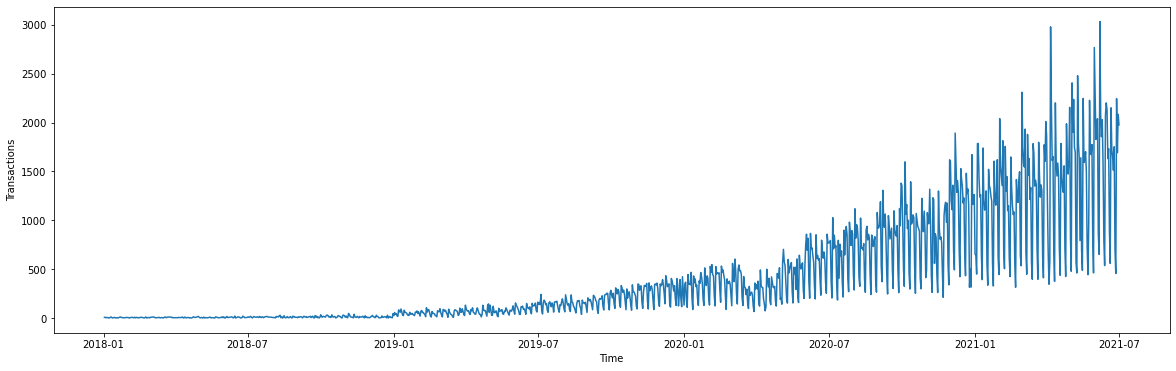

In [576]:
plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")

plt.plot(t2day.date.sort_index())
plt.show()

#### Lets visualize the last year.

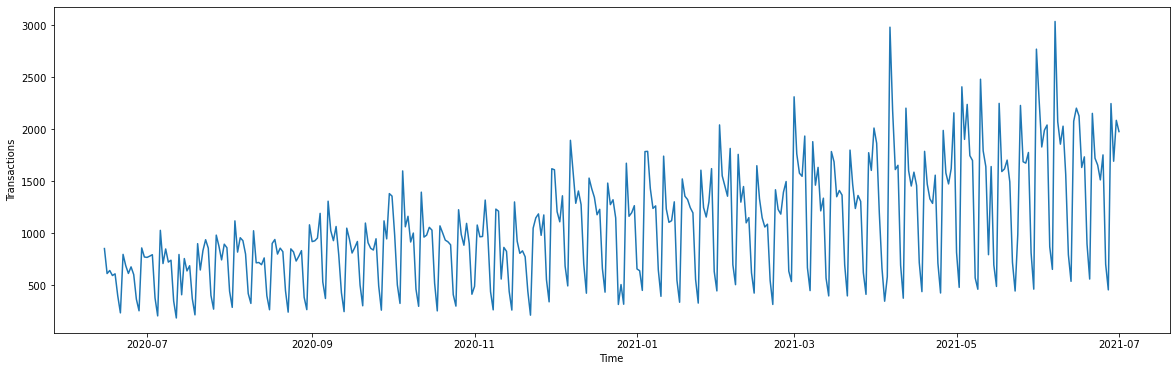

In [577]:
plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")
plt.plot(t2day.date.sort_index()[850:])
plt.plot()
plt.show()

#### Let's visualize the last six months (about 25 weeks)

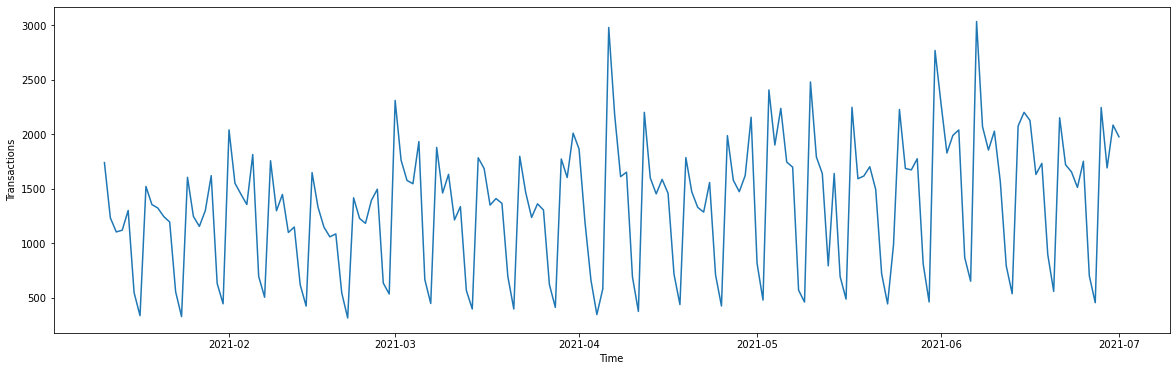

In [578]:
six_months = t2day.date.sort_index()[1060:]

plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")
plt.plot(six_months)
plt.plot()
plt.show()

#### Data decomposition for obtaining trend, seasonality and 

<ipython-input-579-3bcb543e1294>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomp = seasonal_decompose(six_months, model = 'additive', freq = 7)


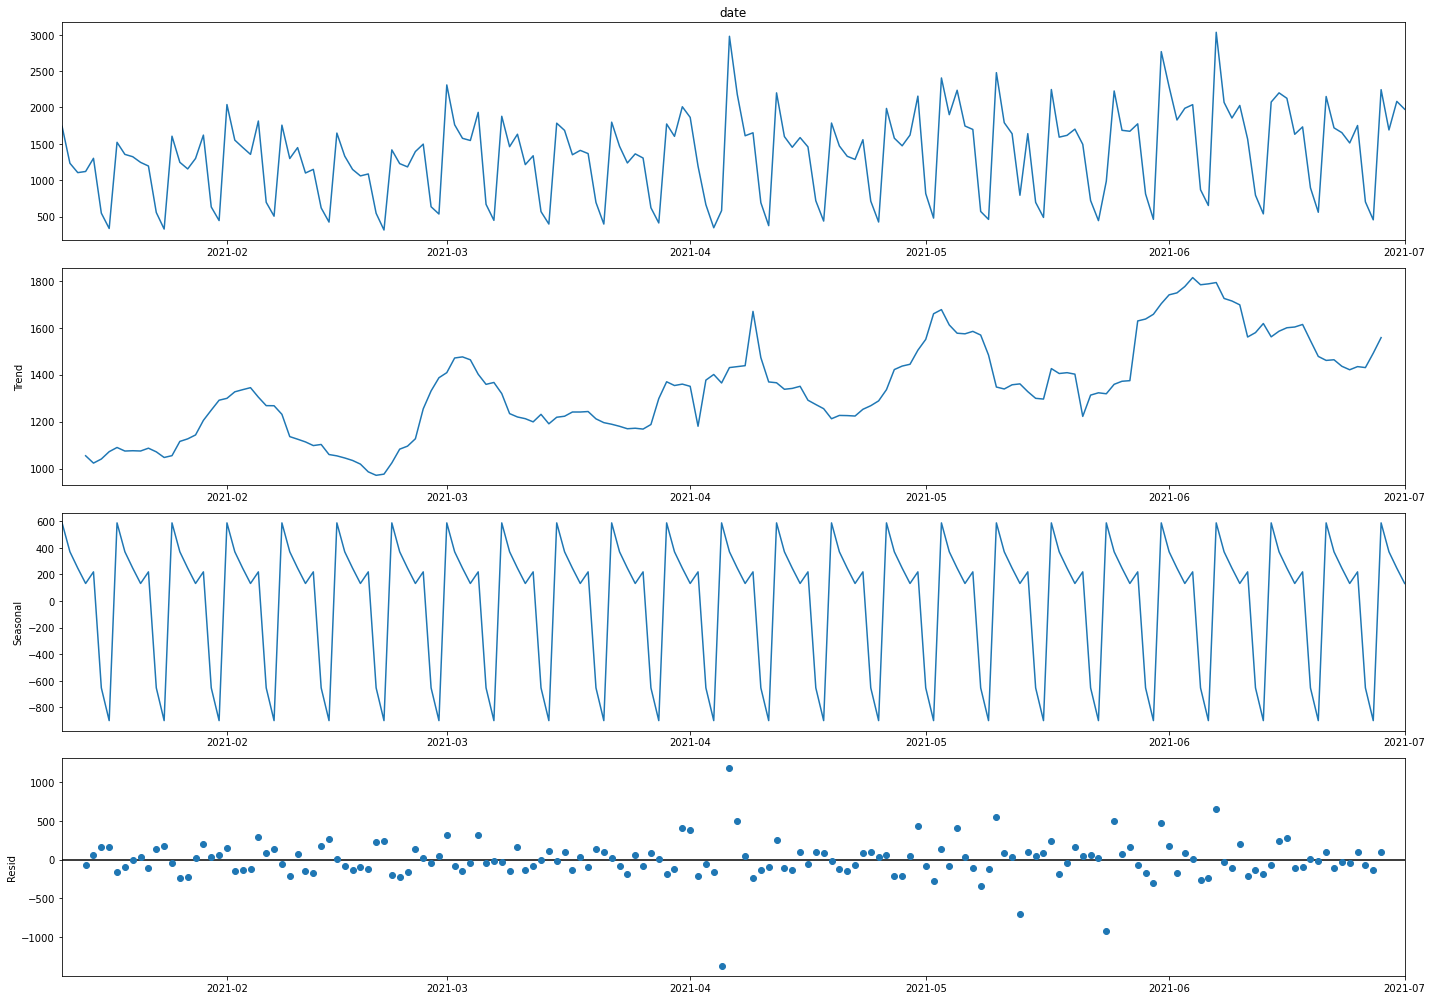

In [579]:
decomp = seasonal_decompose(six_months, model = 'additive', freq = 7)

with plt.rc_context(): 
    plt.rc("figure", figsize = (20, 14))
    decomp.plot()
    plt.show()

#### How are transactions per accounts distributed ?

In [580]:
t2a = trs['account_id'].value_counts()

In [581]:
t2a

210     3427
1005    3388
1248    3388
235     3283
662     2896
        ... 
384        1
906        1
600        1
1122       1
125        1
Name: account_id, Length: 1254, dtype: int64

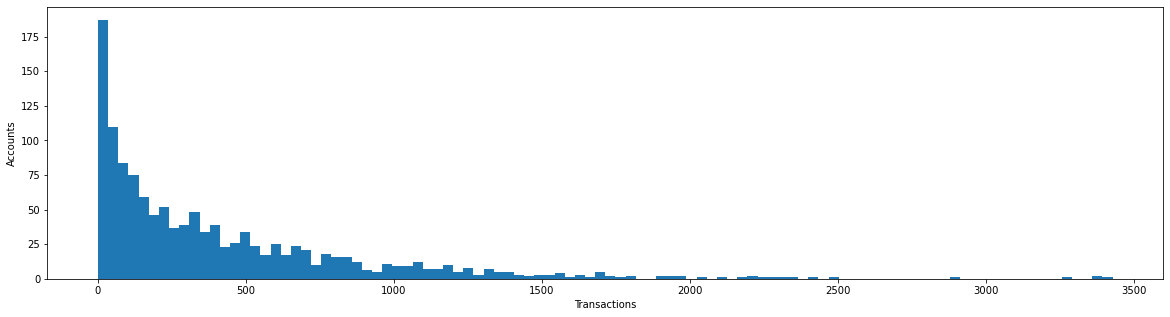

In [582]:
plt.figure(figsize = (20, 5))
plt.xlabel("Transactions")
plt.ylabel("Accounts")

plt.hist(t2a, bins = 100)
plt.show()

#### When is the great majority of the transactions made? During the weekends of during the weekdays?

In [583]:
# the weekdays go from 1-5, while the weekends 6-7
def get_dayofweek(date): 
    data = pd.Timestamp(date)
    dayofweek = date.weekday()
    return dayofweek

trs['day_of_week'] = trs['date'].apply(lambda x : get_dayofweek(x))

In [584]:
trs.head()

,account_id,date,amount,day_of_week
0,0,2020-10-16,200.0,4
1,0,2020-10-16,-192.0,4
2,0,2020-10-16,200.0,4
3,0,2020-10-16,-24.0,4
4,0,2020-10-16,-50.0,4


In [585]:
weekdays_trs = trs[trs['day_of_week'] < 6]
weekends_trs = trs[trs['day_of_week'] > 5]

In [586]:
print('number of trs during the weekdays = ', len(weekdays_trs))
print('number of trs during the weekends = ', len(weekends_trs))

number of trs during the weekdays =  492244
number of trs during the weekends =  25985


####  When are the negative transactions made ? During the weekdays of during the weekends? 

In [587]:
neg_trs_weekdays = weekdays_trs[weekdays_trs['amount'] < 0]
neg_trs_weekends = weekends_trs[weekends_trs['amount'] < 0]

In [588]:
print('number of negative trs during the weekdays = ', len(neg_trs_weekdays))
print('number of negative trs during the weekends = ', len(neg_trs_weekends))

number of negative trs during the weekdays =  388259
number of negative trs during the weekends =  22684


In [589]:
print('percentage of negative trs during the weekdays = ',  len(neg_trs_weekdays) / len(weekdays_trs) * 100)
print('percentage of negative trs during the weekends = ',  len(neg_trs_weekends) / len(weekends_trs) * 100)

percentage of negative trs during the weekdays =  78.87531386873177
percentage of negative trs during the weekends =  87.29651722147392


#### Compute and Visualize all the negative transactions

In [590]:
all_negative_trs = trs[trs['amount'] < 0]

In [591]:
sorted_neg_trs = all_negative_trs['date'].value_counts().sort_values()
sorted_neg_trs = sorted_neg_trs.to_frame()

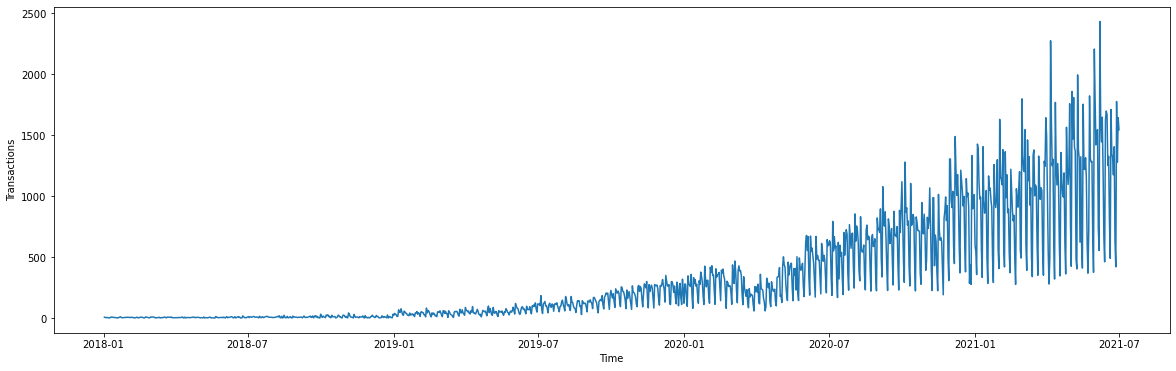

In [592]:
plt.figure(figsize = (20, 6))
plt.xlabel("Time")
plt.ylabel("Transactions")
plt.plot(sorted_neg_trs.date.sort_index())
plt.plot()
plt.show()



#### Apply Autoregression to the data in order to predict negative trasactions 

In [593]:
from statsmodels.tsa.ar_model import AR
from numpy import mean
from sklearn.metrics import mean_squared_error

In [594]:
# prepare the data for autoregression 
X = sorted_neg_trs.date.sort_index()

In [595]:
# split dataset
prediction_period = 30
train, test = X[1:len(X)- prediction_period], X[len(X)-prediction_period:]

In [596]:
print(len(train))
print(len(test))

1182
30


In [597]:
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

Lag: 22
Coefficients: const       3.976482
L1.date     0.134557
L2.date     0.073681
L3.date     0.158224
L4.date     0.029725
L5.date     0.141553
L6.date     0.171127
L7.date     0.339754
L8.date    -0.153178
L9.date    -0.034970
L10.date   -0.150634
L11.date    0.096407
L12.date   -0.116076
L13.date   -0.096131
L14.date    0.210491
L15.date    0.054078
L16.date   -0.067766
L17.date   -0.001022
L18.date   -0.111039
L19.date   -0.047963
L20.date   -0.023690
L21.date    0.384933
L22.date    0.021489
dtype: float64


C:\Users\alket\anaconda3\envs\ds10\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWa

In [598]:
predictions.values

array([1361.07053012, 1329.56533708, 1207.13234876,  880.29532326,
        692.62806882, 1741.38382625, 1576.0210263 , 1393.39482642,
       1270.23796039, 1426.80571207,  796.54355362,  481.61137424,
       1405.18344083, 1708.15982751, 1350.4789586 , 1301.02393216,
       1277.1080197 ,  627.815384  ,  475.17576509, 1753.29017731,
       1793.26692403, 1371.16126213, 1327.59207405, 1246.0560457 ,
        840.42639698,  695.46854849, 1716.47243274, 1744.37140713,
       1413.42914865, 1334.63253552])

In [599]:
for i in range(len(predictions)):
    print('predicted= %f, expected=%f' % (predictions.values[i], test[i]) )

predicted= 1361.070530, expected=1419.000000
predicted= 1329.565337, expected=1528.000000
predicted= 1207.132349, expected=1544.000000
predicted= 880.295323, expected=742.000000
predicted= 692.628069, expected=554.000000
predicted= 1741.383826, expected=2431.000000
predicted= 1576.021026, expected=1635.000000
predicted= 1393.394826, expected=1444.000000
predicted= 1270.237960, expected=1647.000000
predicted= 1426.805712, expected=1216.000000
predicted= 796.543554, expected=665.000000
predicted= 481.611374, expected=461.000000
predicted= 1405.183441, expected=1624.000000
predicted= 1708.159828, expected=1697.000000
predicted= 1350.478959, expected=1668.000000
predicted= 1301.023932, expected=1250.000000
predicted= 1277.108020, expected=1326.000000
predicted= 627.815384, expected=795.000000
predicted= 475.175765, expected=490.000000
predicted= 1753.290177, expected=1710.000000
predicted= 1793.266924, expected=1343.000000
predicted= 1371.161262, expected=1320.000000
predicted= 1327.592074

In [600]:
# transform predictions into dataframe and visualize it 
preds = pd.DataFrame(test.index, predictions.values)

In [601]:
preds.reset_index(inplace = True)
preds.head(2)

,index,0
0,1361.070530,2021-06-02
1,1329.565337,2021-06-03


In [602]:
preds = preds['index'].squeeze()

In [603]:
preds.index = test.index

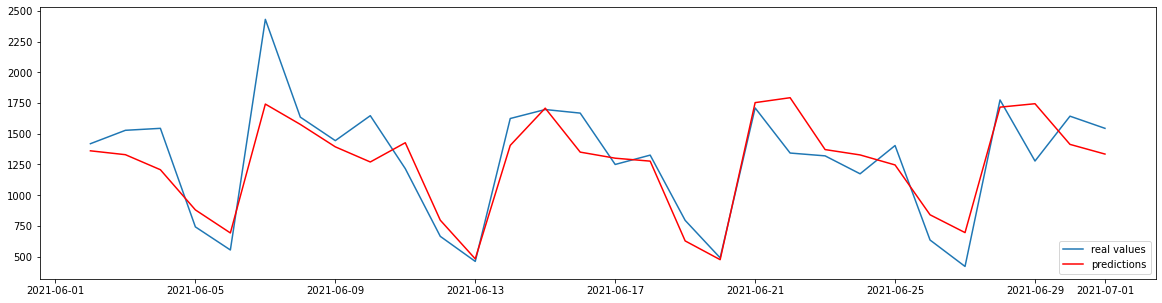

In [604]:
# plot results
plt.figure(figsize=(20, 5))
# Function add a legend  
plt.plot(test)
plt.plot(preds, color='red')
plt.legend(["real values", "predictions"], loc ="lower right")
plt.show()

### Compute the forecasting error 

In [605]:
err = test.values - preds.values

In [606]:
MAE = np.mean(np.abs(err))
RMSE = math.sqrt(mean_squared_error(test, predictions))
MAPE = np.mean(np.abs(err / test.values)) * 100

In [607]:
print('Mean Absolute Error = ', MAE)
print('Root Mean Square Error', RMSE)
print('Mean Absolute Percentage Error = ', MAPE )

Mean Absolute Error =  184.64956652139105
Root Mean Square Error 241.77044055218005
Mean Absolute Percentage Error =  15.900339063800539
